In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os


In [62]:
class Custom_CV:
    @staticmethod
    def padding(img,kernelsize):
        # padding
        padx = kernelsize[0]-1
        pady = kernelsize[1]-1
        padded_img = np.zeros((img.shape[0]+padx,img.shape[1]+pady))
        padded_img[padx//2:img.shape[0]+padx//2,pady//2:img.shape[1]+pady//2] = img
        
        if pady>0:
            padded_img[:,0:pady//2] = padded_img[:,slice(pady//2,0,-1)]
            padded_img[:,-pady//2:] = padded_img[:,slice(-pady//2-1,-1,1)]
            
        if padx>0:
            padded_img[0:padx//2,:] = padded_img[slice(padx//2,0,-1),:]
            padded_img[-padx//2:,:] = padded_img[slice(-padx//2-1,-1,1),:]
        return padded_img
    @staticmethod
    def apply_convolution(img,kernel):
        kernelsize_x,kernelsize_y = kernel.shape
        image_height,image_width = img.shape
        padded_img = Custom_CV.padding(img,kernel.shape)
        conv_img = np.zeros_like(img)
        
        # convolution
        for i in range(kernelsize_x):
            for j in range(kernelsize_y):
                conv_img += padded_img[i:image_height+i, j:image_width+j] * kernel[i, j]
        return conv_img

    @staticmethod
    def sobel(img,dir):
        if dir == 'x':
            # mn complexity 
            # kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])        
            # seperate kernels => m+n complexity
            kernelx = np.array([[-1,0,1]])
            kernely = np.array([[1],[2],[1]])
        else:
            # kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
            kernelx = np.array([[1,2,1]])
            kernely = np.array([[1],[0],[-1]])

        convx = Custom_CV.apply_convolution(img,kernelx)
        convxy = Custom_CV.apply_convolution(convx,kernely)
        return convxy

    @staticmethod
    def gaussian_blur(img,ksize,sigma):
        if sigma == 0:
            sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
        kernelx = np.zeros((ksize,))
        for i in range(ksize):
                kernelx[i] = np.exp(-((i-1)**2)/(2*sigma**2))
        # kernel = kernel/np.sum(kernel)
        kernelx = kernelx.reshape(1,-1)
        kernely = kernelx.reshape(-1,1)
        convx = Custom_CV.apply_convolution(img,kernelx)
        convxy = Custom_CV.apply_convolution(convx,kernely)
        return convxy

    def non_max_suppression(dst,kernelsize):
        padded_dst = Custom_CV.padding(dst,kernelsize)
        for i in range(dst.shape[0]):
            for j in range(dst.shape[1]):
                if dst[i,j] != np.max(padded_dst[i:i+kernelsize[0],j:j+kernelsize[1]]):
                    dst[i,j] = 0
        return dst


    @staticmethod
    def harris_corners(gray,sobelxx,sobelyy,sobelxy,block_size,k=0.04):
        dist = []
        for  xpixel in range(gray.shape[0]):
            dist_row = []
            for ypixel in range(gray.shape[1]):
                if xpixel < block_size//2 or xpixel > gray.shape[0]-block_size//2 or ypixel < block_size//2 or ypixel > gray.shape[1]-block_size//2:
                    M = np.array([
                    [sobelxx[xpixel][ypixel],sobelxy[xpixel][ypixel]],
                    [sobelxy[xpixel][ypixel],sobelyy[xpixel][ypixel]]])
                else:
                    slice_ = lambda x: slice(x-block_size//2,x+block_size//2+1)
                    M = np.array([
                    [np.sum(sobelxx[slice_(xpixel),slice_(ypixel)]), np.sum(sobelxy[slice_(xpixel),slice_(ypixel)])],
                    [np.sum(sobelxy[slice_(xpixel),slice_(ypixel)]), np.sum(sobelyy[slice_(xpixel),slice_(ypixel)])]])

                det_M = np.linalg.det(M)
                trace_M = np.trace(M)
                R = det_M - k*(trace_M**2)
                dist_row.append(R)
            dist.append(dist_row)
        dist = np.array(dist)
        dist_prev = dist.copy()
        for kernerl_size in range(3,9,2):
            dist = Custom_CV.non_max_suppression(dist,(kernerl_size,kernerl_size))
            if np.array_equal(dist,dist_prev):
                break
            dist_prev = dist.copy()
        return dist
    
    def HarrisCornerDetector(self,img_dir,block_size,k=0.04,ksize=3,imshow=False):
        img = cv.imread(img_dir)
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        sobelx = Custom_CV.sobel(gray,'x')
        sobely = Custom_CV.sobel(gray,'y')
        sobelxy = sobelx*sobely
        sobelxx = sobelx*sobelx
        sobelyy = sobely*sobely
        sobelxx = Custom_CV.gaussian_blur(sobelxx,ksize,0)
        sobelyy = Custom_CV.gaussian_blur(sobelyy,ksize,0)
        sobelxy = Custom_CV.gaussian_blur(sobelxy,ksize,0)
        
        dst = Custom_CV.harris_corners(gray,sobelxx,sobelyy,sobelxy,block_size,k)
        threshold = np.where(dst>0.01*dst.max())
        [cv.circle(img,(i,j),1,(0,0,255),-1) for  j, i in zip(threshold[0],threshold[1])]    
        
        if imshow:    
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            plt.imshow(img)
        return img,dst

In [22]:
os.listdir("Assignment 1 Input Images/Question 1/")

['1.gif',
 '10.jpg',
 '11.jpg',
 '2.jpeg',
 '3.png',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpeg']

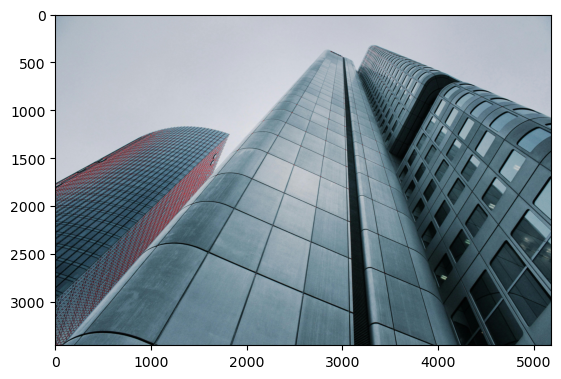

In [23]:
img,dst = openCV_HarrisCornerDetector("Assignment 1 Input Images/Question 1/7.jpg")
img = cv.cvtColor(img,cv.COLOR_BGR2RGB) 
plt.imshow(img)

In [27]:
kernelx = np.array([[-1,0,1]])

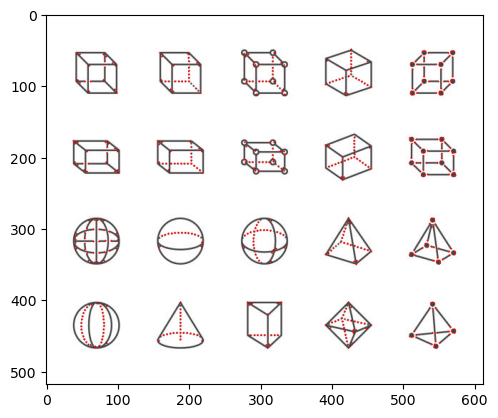

In [65]:
filename = r'C:\Users\KHADGA JYOTH ALLI\Desktop\programming\Class Work\IITJ\Computer Vision\Assignment1\Assignment 1 Input Images\Question 1\10.jpg'
img,dst = Custom_CV().HarrisCornerDetector(filename,2,0.04,3,True)


In [ ]:
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
sobelx = Custom_CV.sobel(gray,'x')
print("here")
sobely = Custom_CV.sobel(gray,'y')
sobelxy = sobelx*sobely
ksize = 3

sobelxx = sobelx*sobelx
sobelyy = sobely*sobely
sobelxx = Custom_CV.gaussian_blur(sobelxx,ksize,0)
sobelyy = Custom_CV.gaussian_blur(sobelyy,ksize,0)
sobelxy = Custom_CV.gaussian_blur(sobelxy,ksize,0)



here


In [ ]:


def openCV_HarrisCornerDetector(image_dir):    
    img = cv.imread(image_dir)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv.cornerHarris(gray,2,3,0.04)
    img[dst>0.01*dst.max()]=[0,0,255]
    return img,dst

def Compare_Harris_opencv(imagefolder_dir):
    images_dir = os.listdir(imagefolder_dir)
    for file in images_dir:
        if file =="1.gif":
            continue
        img = cv.imread(os.path.join(imagefolder_dir,file))
        image_opencv,dst_opencv = openCV_HarrisCornerDetector(os.path.join(imagefolder_dir,file))
        image_custom,dst_custom = Custom_CV().HarrisCornerDetector(os.path.join(imagefolder_dir,file),2,0.04,3)
        image_opencv = cv.cvtColor(image_opencv,cv.COLOR_BGR2RGB)
        image_custom = cv.cvtColor(image_custom,cv.COLOR_BGR2RGB)
        img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
        fig,ax = plt.subplots(1,3,figsize=(15,15))
        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[1].imshow(image_opencv)
        ax[1].set_title('OpenCV Harris Corner')
        ax[2].imshow(image_custom)
        ax[2].set_title('Custom Harris Corner')
        plt.show()
        # break


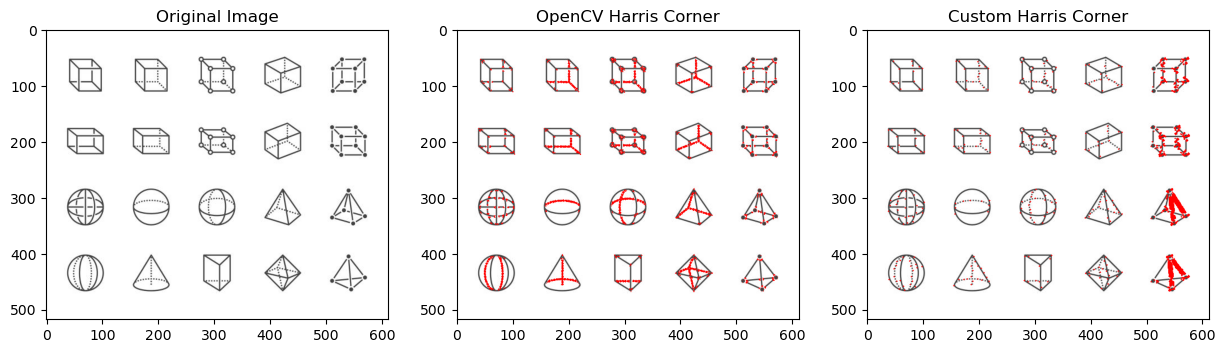

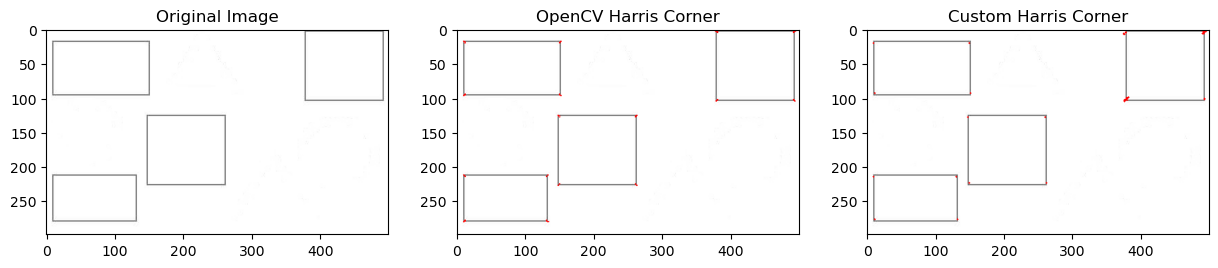

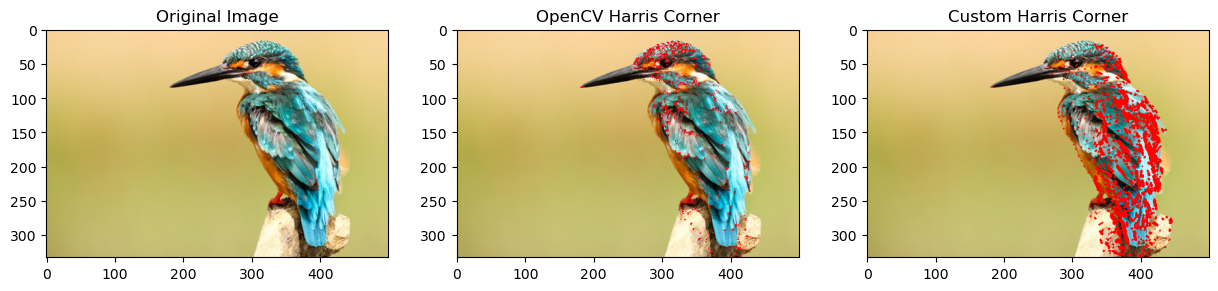

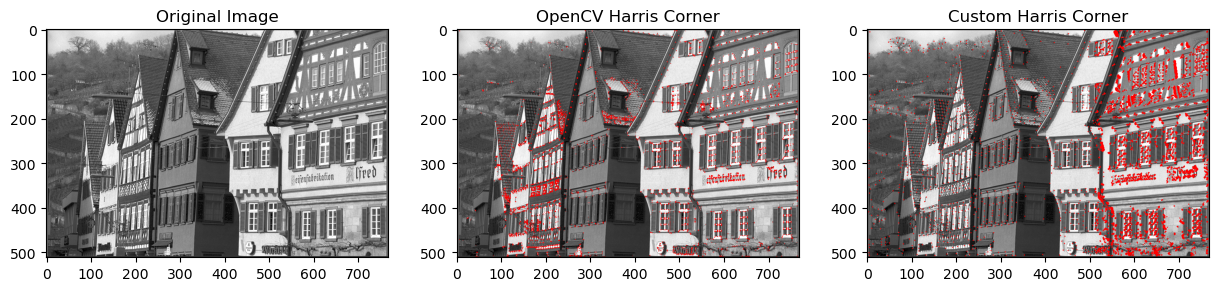

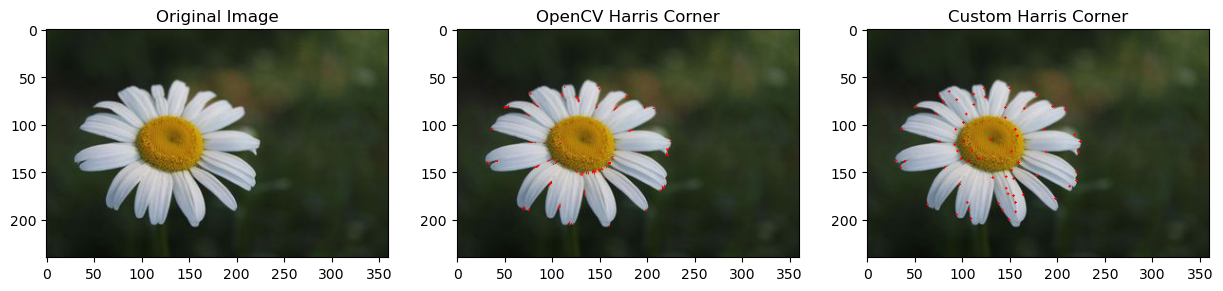

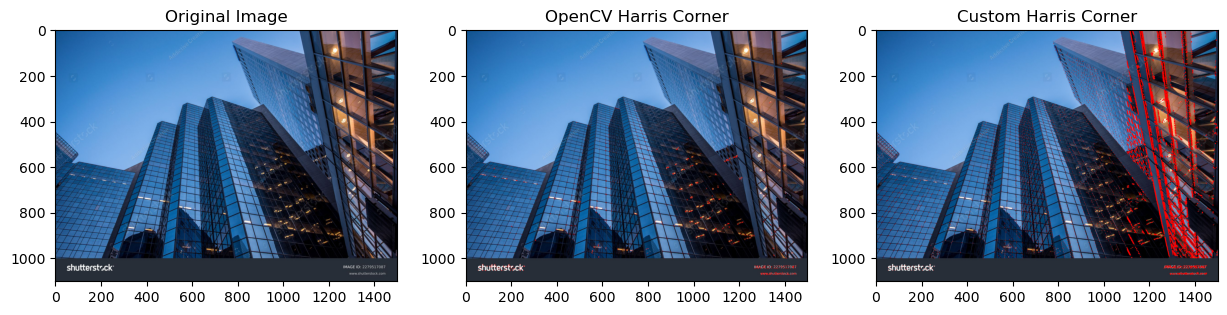

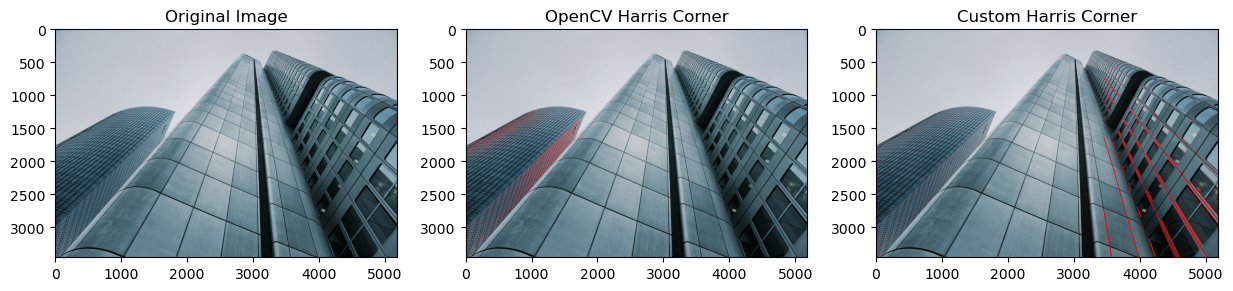

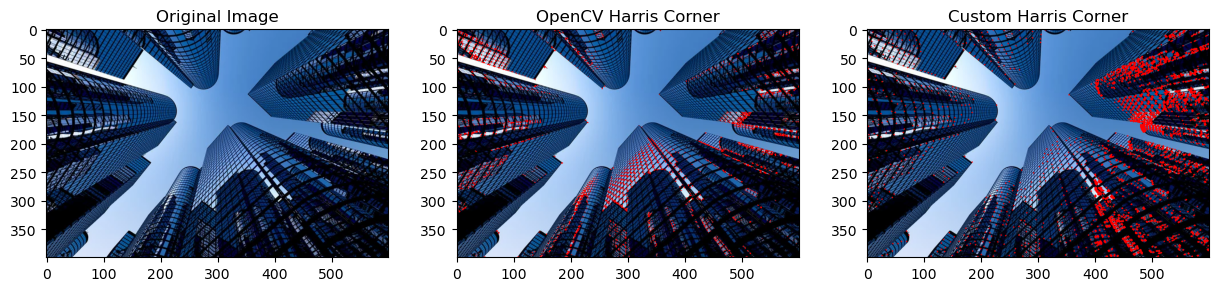

IndexError: index 500 is out of bounds for axis 1 with size 500

In [ ]:
Compare_Harris_opencv(r'C:\Users\KHADGA JYOTH ALLI\Desktop\programming\Class Work\IITJ\Computer Vision\Assignment1\Assignment 1 Input Images\Question 1')